### Web Tracffic with fbprophet
- https://gist.github.com/HyeongWookKim/c8f31f30b233896bb8947622d7efaf82 참고
- https://alpaca-gt.tistory.com/302 에 기록

#### 1. libraries & data load

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from fbprophet import Prophet
from datetime import datetime

In [5]:
pinkwink_web = pd.read_csv("08. PinkWink Web Traffic.csv",
                           encoding = 'utf-8', thousands = ',',
                           names = ['date', 'hit'], index_col = 0)
pinkwink_web = pinkwink_web[pinkwink_web['hit'].notnull()]
pinkwink_web.head(10)

,hit
date,
16. 7. 1.,766.0
16. 7. 2.,377.0
16. 7. 3.,427.0
16. 7. 4.,902.0
16. 7. 5.,850.0
16. 7. 6.,876.0
16. 7. 7.,868.0
16. 7. 8.,785.0
16. 7. 9.,417.0


- 2016년 7월 1일부터 2017년 6월 16일까지의 유입량

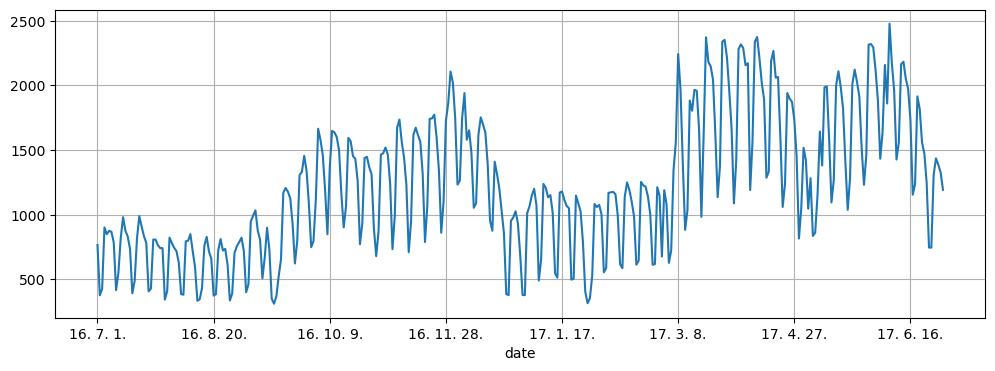

In [4]:
pinkwink_web['hit'].plot(figsize = (12, 4), grid = True);

 - '선형 회귀 직선' 및 '다항 회귀식'을 표현

In [8]:
time = np.arange(0, len(pinkwink_web)) # 시간축(time) 생성 (0부터 365까지)
traffic = pinkwink_web['hit'].values   # 웹 트래픽의 자료를 traffic 변수에 저장

fx = np.linspace(0, time[-1], 1000)    # 0부터 364까지를 1000개로 분할

- RMSE(Root Mean Square Error)을 계산해주는 error() 함수를 생성

In [9]:
def error(f, x, y):
    return np.sqrt(np.mean((f(x) - y) ** 2)) # RMSE(Root Mean Square Error)

- 각 차수별 다항식의 'RMSE(Root Mean Square Error)'을 계산하고, 결과를 시각화
    - 1차, 2차, 3차 다항식의 RMSE(Root Mean Square Error)는 거의 비슷
    - 15차 다항식의 RMSE(Root Mean Square Error)는 비교적 낮음
    - => 모델이 복잡해질수록 주어진 데이터에 대한 fitting 정확도가 높아지기 때문
    - => 모델이 너무 복잡하면 과적합(overfitting) 문제가 발생

In [10]:
# 1차 다항식
fp1 = np.polyfit(time, traffic, 1)
f1 = np.poly1d(fp1)

# 2차 다항식
f2p = np.polyfit(time, traffic, 2)
f2 = np.poly1d(f2p)

# 3차 다항식
f3p = np.polyfit(time, traffic, 3)
f3 = np.poly1d(f3p)

# 15차 다항식
f15p = np.polyfit(time, traffic, 15)
f15 = np.poly1d(f15p)

# 각 차수별 다항식의 '잔차 제곱합'을 계산
print(error(f1, time, traffic))
print(error(f2, time, traffic))
print(error(f3, time, traffic))
print(error(f15, time, traffic))

430.85973081109626
430.6284101894695
429.5328046676293
330.4777305307993


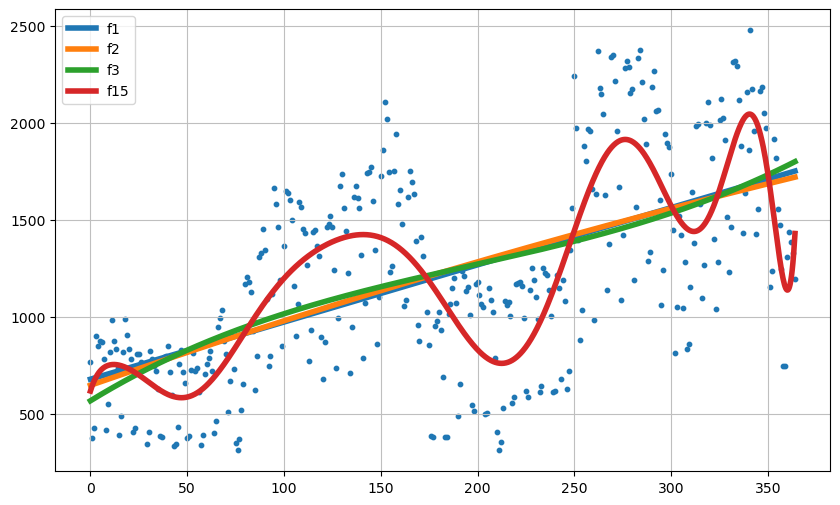

In [11]:
plt.figure(figsize = (10, 6))
plt.scatter(time, traffic, s = 10)

plt.plot(fx, f1(fx), lw = 4, label = 'f1')
plt.plot(fx, f2(fx), lw = 4, label = 'f2')
plt.plot(fx, f3(fx), lw = 4, label = 'f3')
plt.plot(fx, f15(fx), lw = 4, label = 'f15')

plt.grid(True, linestyle = '-', color = '0.75')

plt.legend(loc = 2)
plt.show()

#### 2. Prophet 모듈을 이용한 forecast 예측
- pinkwink_web 변수에서 날짜(index), 방문수(hit)만 따로 저장
- pandas의 to_datetime() 함수를 사용해서 'ds' 변수를 날짜로 선언
- Prophet() 함수를 사용할 때, 주기성이 연단위(yearly_seasonality) 및 일단위(daily_seasonality)

In [13]:
df = pd.DataFrame({'ds': pinkwink_web.index, 'y': pinkwink_web['hit']})
df.reset_index(inplace = True)

df['ds'] = pd.to_datetime(df['ds'], format = "%y. %m. %d.") # "yyyy-mm-dd" 형태로 변경

# 'ds' 변수를 생성해줬으므로, 'date' 변수는 삭제
del df['date']

m = Prophet(yearly_seasonality = True, daily_seasonality = True)
m.fit(df)

Initial log joint probability = -10.2116


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       807.567   0.000255087       99.9551           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     164        807.88    2.3207e-08       97.7285      0.5945      0.5945      200   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


- make_future_dataframe()로 지정된 날짜 수만큼 미래로 확장하는 적절한 데이터 프레임 얻기
    - 60일간 데이터 예측하기

In [15]:
df

,ds,y
0,2016-07-01,766.0
1,2016-07-02,377.0
2,2016-07-03,427.0
3,2016-07-04,902.0
4,2016-07-05,850.0
...,...,...
360,2017-06-26,1309.0
361,2017-06-27,1436.0
362,2017-06-28,1387.0
363,2017-06-29,1328.0


In [14]:
future = m.make_future_dataframe(periods = 60)
future.tail()

,ds
420,2017-08-25
421,2017-08-26
422,2017-08-27
423,2017-08-28
424,2017-08-29


- predict()를 사용하여 예측한 데이터를 forecast 변수에 저장

In [16]:
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-07-01,825.306556,520.164401,966.363042,825.306556,825.306556,-91.816455,-91.816455,-91.816455,239.028086,...,-51.472808,-51.472808,-51.472808,-279.371733,-279.371733,-279.371733,0.0,0.0,0.0,733.490101
1,2016-07-02,826.131344,115.565285,520.254406,826.131344,826.131344,-523.974561,-523.974561,-523.974561,239.028086,...,-467.460182,-467.460182,-467.460182,-295.542465,-295.542465,-295.542465,0.0,0.0,0.0,302.156783
2,2016-07-03,826.956132,209.900352,641.927139,826.956132,826.956132,-404.916701,-404.916701,-404.916701,239.028086,...,-335.316985,-335.316985,-335.316985,-308.627802,-308.627802,-308.627802,0.0,0.0,0.0,422.039431
3,2016-07-04,827.780919,757.857964,1166.136094,827.780919,827.780919,137.463908,137.463908,137.463908,239.028086,...,217.282127,217.282127,217.282127,-318.846306,-318.846306,-318.846306,0.0,0.0,0.0,965.244827
4,2016-07-05,828.605707,768.956630,1217.561716,828.605707,828.605707,166.007961,166.007961,166.007961,239.028086,...,253.438787,253.438787,253.438787,-326.458912,-326.458912,-326.458912,0.0,0.0,0.0,994.613668


- 확인해보고자 하는 변수들만 뽑아내서 확인
    - 'ds', 'yhat', 'yhat_lower', 'yhat_upper' 

In [17]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
420,2017-08-25,903.099306,706.436431,1119.739400
421,2017-08-26,488.060886,274.972501,694.432022
422,2017-08-27,620.685635,410.792332,838.333930
423,2017-08-28,1173.384770,959.990346,1392.779293
424,2017-08-29,1209.371367,982.148504,1399.060967


- 시각화를 통해 예측 결과를 확인
    - 2017년 6월 말까지의 데이터 이후, 약 2개월(60일)의 예측 결과
    - 단순히 다항식으로 경향을 파악하는 것보다 더 효과적

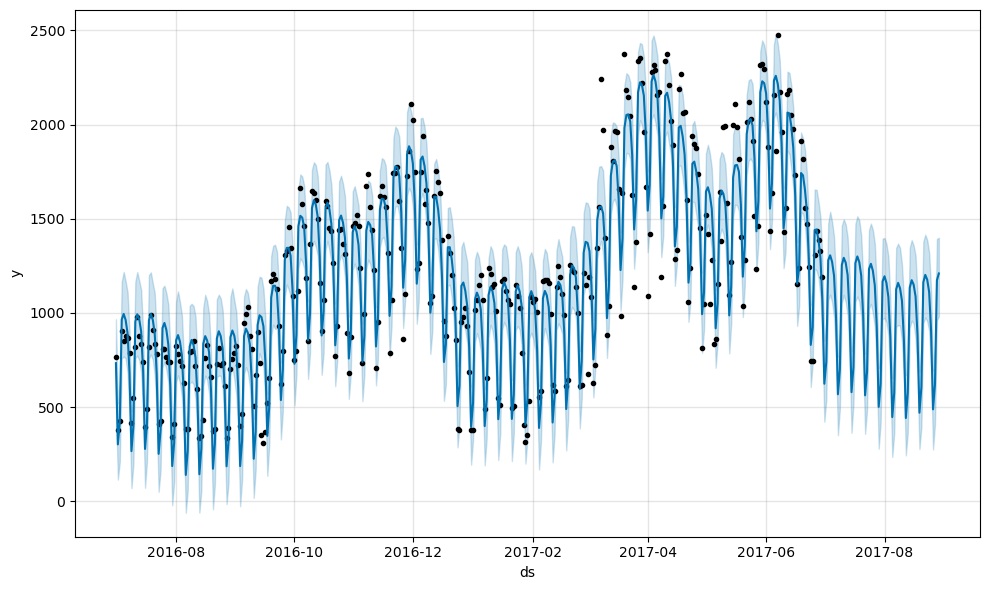

In [18]:
m.plot(forecast);

- plot_components()를 사용해서 선형 회귀 및 계절성 성분 별로 분해
    - forecast component 시각화 (Trend, Holidays, Weakly, Yearly, Daily)

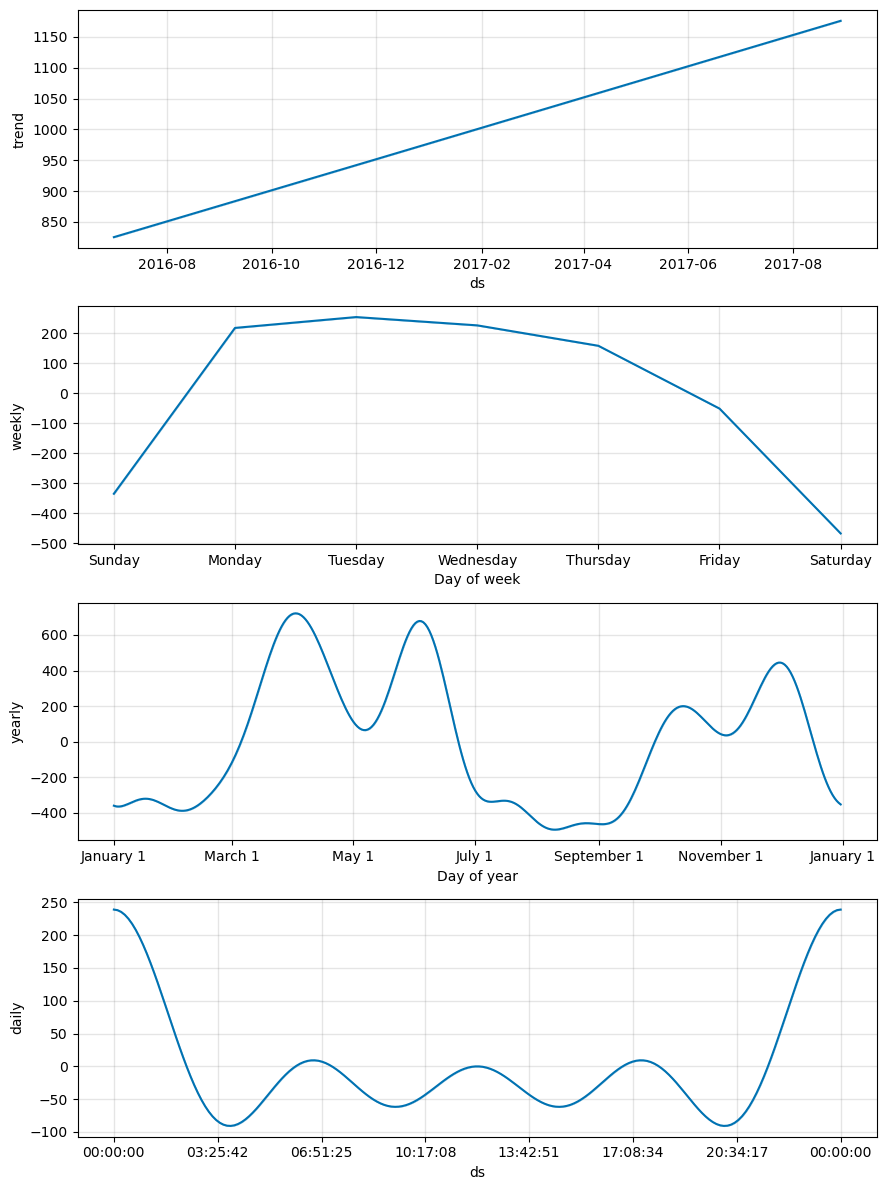

In [19]:
m.plot_components(forecast);

추세성 (Trend)	: 데이터의 장기적 변동 <br>
순환성 (Cycle)	: 주기를 가지지만 일정하지 않고 반복이 없는 데이터의 변동<br>
계절성 (Seasonality)	: 일정한 주기를 가지고 반복되는 데이터의 변동<br>
불규칙성 (Noise)	: 알 수 없거나 돌발적인 요인에 의해 발생하는 데이터의 변동<br>